In [ ]:
!git clone https://github.com/oladeha2/shot_boudary_detector.git

Cloning into 'shot_boudary_detector'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.


In [ ]:
%cd /content/
!ls

/content
ab_cut_22_norm.txt  labdiff.txt  sample_data
frm.txt		    NAD57.mpg	 shot_boudary_detector


In [ ]:
%cd /content/shot_boudary_detector
!ls

/content/shot_boudary_detector
get_transition_frames_cpu.py		TestVideo.py
get_transition_frames_gpu.py		transition_network.py
README.md				utilities.py
shot_boundary_detector_even_distrib.pt	video_processing.py
snippet.py


In [ ]:
import sys
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from snippet import getSnippet
from math import floor
from transition_network import TransitionCNN
from utilities import normalize_frame, print_shape
import pandas as pd
import os
import time
from TestVideo import TestVideo, return_start_and_end
from moviepy.editor import VideoFileClip
from video_processing import six_four_crop_video
from PIL import Image

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory 

video = sys.argv[1]
pred_text_file_name = sys.argv[2]


text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
os.makedirs('predictions/', exist_ok=True)

vid = VideoFileClip(video)
vid = six_four_crop_video(vid)

frames = [frame for frame in vid.iter_frames()]

f = open(text_file, 'w+')

for j, frame in enumerate(frames):
        frame_path = frames_path + 'frame_' + str(j+1) + '.png'
        im = Image.fromarray(frame)
        im.save(frame_path)            
        f.write(frame_path + '\n')    

print('frame decomposition complete !!! ')

device = 'cuda'

#load model
model = TransitionCNN()
model.load_state_dict(torch.load('shot_boundary_detector_even_distrib.pt'))
model.to(device)

prediction_text_file = 'predictions/' + pred_text_file_name 

pred_file = open(prediction_text_file, 'w+')

print('computing predictions for video', video, '...................' )

test_video = TestVideo('frames.txt', sample_size=100, overlap=9)
test_loader = DataLoader(test_video, batch_size=1, num_workers=1)

video_indexes = []
vals = np.arange(test_video.get_line_number())
length = len(test_video)

for val in range(length):
    s,e = return_start_and_end(val)
    video_indexes.append(vals[s:e])

for indx, batch in enumerate(test_loader):
        batch.to(device)
        batch = batch.type('torch.cuda.FloatTensor')
        predictions = model(batch)
        predictions = predictions.argmax(dim=1).cpu().numpy()
        for idx, prediction_set in enumerate(predictions):
            for i, prediction in enumerate(prediction_set):
                if prediction[0][0] == 0:
                    frame_index = video_indexes[indx][i+5]
                    pred_file.write(str(frame_index) + '\n')
pred_file.close()

# delete files used for process
os.remove('frames.txt')
shutil.rmtree('video_frames/')

print('Predictions complete !!!')
print('Frames that are part of shot boundaries are listed in file the directory path predictions/' + pred_text_file_name)














In [ ]:
#ABRUPT TRANSITION
import sys
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from snippet import getSnippet
from math import floor
from transition_network import TransitionCNN
from utilities import normalize_frame, print_shape
import pandas as pd
import numpy as np
import cv2
#from ciede2000 import CIEDE2000

import os
import time
from TestVideo import TestVideo, return_start_and_end
from moviepy.editor import VideoFileClip
from video_processing import six_four_crop_video
from PIL import Image
import math

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

video = sys.argv[1]
pred_text_file_name = sys.argv[2]


text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
os.makedirs('predictions/', exist_ok=True)
fr = []
vid = VideoFileClip(video)
vid = six_four_crop_video(vid)

frames = [frame for frame in vid.iter_frames()]

f = open(text_file, 'w+')

for j, frame in enumerate(frames):
        frame_path = frames_path + 'frame_' + str(j+1) + '.png'
        im = Image.fromarray(frame)
        mean = np.mean(im)
        fr.append(im)
        im.save(frame_path)            
        f.write(frame_path + '\n')    

print('frame decomposition complete !!! ')

ab_cut = []
for i in range(2,(len(fr)-1)):
  #Lab1 = cv2.cvtColor(frames_path + 'frame_' + str(i+1) + '.png', cv2.COLOR_BGR2Lab)
  #Lab2 = cv2.cvtColor(frames_path + 'frame_' + str(i+2) + '.png', cv2.COLOR_BGR2Lab)
  image0 = cv2.imread(frames_path + 'frame_' + str(i-1) + '.png')
  image1 = cv2.imread(frames_path + 'frame_' + str(i) + '.png')
  image2 = cv2.imread(frames_path + 'frame_' + str(i+1) + '.png')
  image3 = cv2.imread(frames_path + 'frame_' + str(i+2) + '.png')
  image0 = np.float32(image0)
  image0 *= 1./255
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255
  image3 = np.float32(image2)
  image3 *= 1./255

  Lab0 = cv2.cvtColor(image0, cv2.COLOR_BGR2Lab)
  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
#print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)
  Lab3 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)

  L0, a0, b0 = cv2.split(Lab0)
  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)
  L3, a3, b3 = cv2.split(Lab3)

#print(L1.shape)
#print(a1)
  diffi = 0
  diffiminus1 = 0
  diffiplus1 = 0
  for k in range(0,64):
    for j in range(0,64):
      diffi = diffi + CIEDE2000((L1[k][j], a1[k][j], b1[k][j]), (L2[k][j], a2[k][j], b2[k][j]))
      diffiminus1 = diffiminus1 + CIEDE2000((L0[k][j], a0[k][j], b0[k][j]), (L1[k][j], a1[k][j], b1[k][j]))
      diffiplus1 = diffiplus1 + CIEDE2000((L2[k][j], a2[k][j], b2[k][j]), (L3[k][j], a3[k][j], b3[k][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  #print(i)
  #print(diffi)
  diffi = diffi/(64*64*3*10)
  diffiminus1 = diffiminus1/(64*64*3*10)
  diffiplus1 = diffiplus1/(64*64*3*10)
  if((diffi > 0.22)  and (diffiminus1 < 0.22) and (diffiplus1 < 0.22)):
    print(i+1)
    print(diffi)
   # ab_cut.append(i+1)

#print(ab_cut)


# delete files used for process
os.remove('frames.txt')
shutil.rmtree('video_frames/')

print('Predictions complete !!!')
print('Frames that are part of shot boundaries are listed in file the directory path predictions/' + pred_text_file_name)
#print(fr)
print(len(fr))
#print(ab_cut)




In [ ]:
##DECOMPOSITION of video frames 14/03/2021
import sys
import shutil

import numpy as np
from math import floor
import pandas as pd
import numpy as np
import cv2

import os
import time
from PIL import Image
import math

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory


#video = sys.argv[1]
#pred_text_file_name = sys.argv[2]
scale_percent = 25

#calculate the 50 percent of original dimensions
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
#output = cv2.resize(src, dsize)



text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
#os.makedirs('predictions/', exist_ok=True)

f = open(text_file, 'w+')
# Opens the Video file
cap= cv2.VideoCapture('/content/NAD57.mpg')
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    output = cv2.resize(frame, dsize) 
    frame_path = frames_path + 'frame_' + str(i) + '.jpg'
    cv2.imwrite("/content/video_frames/frame_"+ str(i) + ".jpg", output)
    f.write(frame_path + '\n')
    i+=1

cap.release()
cv2.destroyAllWindows()
print("decomposition complete")





decomposing video to frames this may take a while  for large videos :) .....
decomposition complete


In [ ]:
#GRADUAL TRANSITION
import sys
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from snippet import getSnippet
from math import floor
from transition_network import TransitionCNN
from utilities import normalize_frame, print_shape
import pandas as pd
import numpy as np
import cv2
#from ciede2000 import CIEDE2000

import os
import time
from TestVideo import TestVideo, return_start_and_end
from moviepy.editor import VideoFileClip
from video_processing import six_four_crop_video
from PIL import Image
import math
import numpy

def smoothListGaussian(list, strippedXs=False, degree=5):
    window = degree*2-1
    weight = numpy.array([1.0]*window)
    weightGauss = []
    for i in range(window):
        i = i-degree+1
        frac = i/float(window)
        gauss = 1/(numpy.exp((4*(frac))**2))
        weightGauss.append(gauss)
    weight = numpy.array(weightGauss)*weight
    smoothed = [0.0]*(len(list)-window)
    for i in range(len(smoothed)):
        smoothed[i] = sum(numpy.array(list[i:i+window])*weight)/sum(weight)
    return smoothed


# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory 

video = sys.argv[1]
pred_text_file_name = sys.argv[2]


text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
os.makedirs('predictions/', exist_ok=True)
fr = []
vid = VideoFileClip(video)
vid = six_four_crop_video(vid)

frames = [frame for frame in vid.iter_frames()]

f = open(text_file, 'w+')

for j, frame in enumerate(frames):
        frame_path = frames_path + 'frame_' + str(j+1) + '.png'
        im = Image.fromarray(frame)
        mean = np.mean(im)
        fr.append(im)
        im.save(frame_path)            
        f.write(frame_path + '\n')    

print('frame decomposition complete !!! ')
L_mean = []
for i in range(0,len(fr)):
  #Lab1 = cv2.cvtColor(frames_path + 'frame_' + str(i+1) + '.png', cv2.COLOR_BGR2Lab)
  #Lab2 = cv2.cvtColor(frames_path + 'frame_' + str(i+2) + '.png', cv2.COLOR_BGR2Lab)
  image1 = cv2.imread(frames_path + 'frame_' + str(i+1) + '.png')
  #image2 = cv2.imread(frames_path + 'frame_' + str(i+2) + '.png')
  image1 = np.float32(image1)
  image1 *= 1./255
  #image2 = np.float32(image2)
  #image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
#print(Lab1.shape)
  #Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L_mean.append(np.mean(L1))
  #L2, a2, b2 = cv2.split(Lab2)

#print(L1.shape)
#print(a1)
print(L_mean)
print(smoothListGaussian(L_mean))

# delete files used for process
os.remove('frames.txt')
shutil.rmtree('video_frames/')

print('Predictions complete !!!')
print('Frames that are part of shot boundaries are listed in file the directory path predictions/' + pred_text_file_name)
#print(fr)
print(len(fr))





In [ ]:
#GRADUAL TRANSITION WITH BUTTERWORTH LOW PASS FILTER
import sys
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from snippet import getSnippet
from math import floor
from transition_network import TransitionCNN
from utilities import normalize_frame, print_shape
import pandas as pd
import numpy as np
import cv2
from ciede2000 import CIEDE2000

import os
import time
from TestVideo import TestVideo, return_start_and_end
from moviepy.editor import VideoFileClip
from video_processing import six_four_crop_video
from PIL import Image
import math
import numpy
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples




# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory 

video = sys.argv[1]
pred_text_file_name = sys.argv[2]


text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
os.makedirs('predictions/', exist_ok=True)
fr = []
vid = VideoFileClip(video)
vid = six_four_crop_video(vid)

frames = [frame for frame in vid.iter_frames()]

f = open(text_file, 'w+')

for j, frame in enumerate(frames):
        frame_path = frames_path + 'frame_' + str(j+1) + '.png'
        im = Image.fromarray(frame)
        mean = np.mean(im)
        fr.append(im)
        im.save(frame_path)            
        f.write(frame_path + '\n')    

print('frame decomposition complete !!! ')
L_mean = []
for i in range(0,len(fr)):
  #Lab1 = cv2.cvtColor(frames_path + 'frame_' + str(i+1) + '.png', cv2.COLOR_BGR2Lab)
  #Lab2 = cv2.cvtColor(frames_path + 'frame_' + str(i+2) + '.png', cv2.COLOR_BGR2Lab)
  image1 = cv2.imread(frames_path + 'frame_' + str(i+1) + '.png')
  #image2 = cv2.imread(frames_path + 'frame_' + str(i+2) + '.png')
  image1 = np.float32(image1)
  image1 *= 1./255
  #image2 = np.float32(image2)
  #image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
#print(Lab1.shape)
  #Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L_mean.append(np.mean(L1))
  #L2, a2, b2 = cv2.split(Lab2)

#print(L1.shape)
#print(a1)
#print(L_mean)
#print(smoothListGaussian(L_mean))
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(L_mean, cutoff, fs, order)

print(y)


# delete files used for process
os.remove('frames.txt')
shutil.rmtree('video_frames/')

print('Predictions complete !!!')
print('Frames that are part of shot boundaries are listed in file the directory path predictions/' + pred_text_file_name)
#print(fr)
print(len(fr))





In [ ]:
!python image_save.py /content/NAD57.mpg pred.txt

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3432448/45929032 bytes (7.5%)7495680/45929032 bytes (16.3%)11001856/45929032 bytes (24.0%)14974976/45929032 bytes (32.6%)19095552/45929032 bytes (41.6%)23199744/45929032 bytes (50.5%)27213824/45929032 bytes (59.3%)31277056/45929032 bytes (68.1%)35561472/45929032 bytes (77.4%)39608320/45929032 bytes (86.2%)43794432/45929032 bytes (95.4%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
!pip install scikit-image

In [ ]:
import cv2
import numpy as np
from skimage import color


image1 = cv2.imread("/content/video_frames/frame_100.jpg")
print(image1.shape)

(60, 88, 3)


In [ ]:
import cv2
import numpy as np
from skimage import color


image1 = cv2.imread("/content/shot_boudary_detector/video_frames/frame_100.png")
image2 = cv2.imread("/content/shot_boudary_detector/video_frames/frame_101.png")
image1 = np.float32(image)
image1 *= 1./255
image2 = np.float32(image)
image2 *= 1./255


Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
print(Lab1.shape)
Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)

#deltaE_ciede2000 (Lab1, Lab2)
#print(deltaE_ciede2000(Lab1, Lab2))


(64, 64, 3)


In [ ]:
!git clone https://github.com/lovro-i/CIEDE2000.git

Cloning into 'CIEDE2000'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00


frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))





Streaming output truncated to the last 5000 lines.
(60, 88, 3)
11260
11261
0.5161970276671879
(60, 88, 3)
11261
11262
0.9350328926250003
(60, 88, 3)
11262
11263
0.9242532418039462
(60, 88, 3)
11263
11264
0.9424240271749291
(60, 88, 3)
11264
11265
0.906844212302857
(60, 88, 3)
11265
11266
0.4215920131946736
(60, 88, 3)
11266
11267
0.9379462599012004
(60, 88, 3)
11267
11268
0.8849048473342432
(60, 88, 3)
11268
11269
0.8914241222080718
(60, 88, 3)
11269
11270
0.9244497170113657
(60, 88, 3)
11270
11271
0.4127104194859847
(60, 88, 3)
11271
11272
0.8586092068581449
(60, 88, 3)
11272
11273
0.9800135191841208
(60, 88, 3)
11273
11274
0.9188577388006833
(60, 88, 3)
11274
11275
0.9110478008773336
(60, 88, 3)
11275
11276
0.5007928365181765
(60, 88, 3)
11276
11277
0.8392103225734096
(60, 88, 3)
11277
11278
0.8377755448337345
(60, 88, 3)
11278
11279
0.8651903598648937
(60, 88, 3)
11279
11280
0.8352585715168698
(60, 88, 3)
11280
11281
0.43484217969822714
(60, 88, 3)
11281
11282
0.7731822764482879
(60

In [ ]:
#resizing of image
import cv2
 
src = cv2.imread('/content/video_frames/frame_10000.jpg', cv2.IMREAD_UNCHANGED)
print(src.shape)
#percent by which the image is resized
scale_percent = 25

#calculate the 50 percent of original dimensions
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
output = cv2.resize(src, dsize)

print(output.shape)

cv2.imwrite('/content/res.jpg',output) 

(240, 352, 3)
(60, 88, 3)


True

No handles with labels found to put in legend.


1.0
[0.0651073  0.0545278  0.06369678 ... 0.00248362 0.00236874 0.00270808]


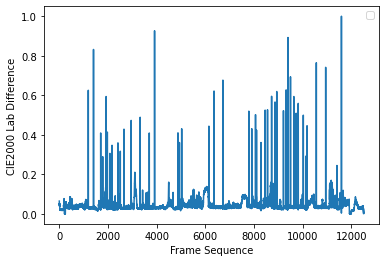

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
plt.savefig('labdiff.jpeg')

In [ ]:
print(frame)
print(labdiff)
np.savetxt('/content/fm.txt', frame, fmt='%s', delimiter=' ')
np.savetxt('/content/labdiff.txt', labdiff, fmt='%s', delimiter=' ')


[    1     2     3 ... 12507 12508 12509]
[0.0651073  0.0545278  0.06369678 ... 0.00248362 0.00236874 0.00270808]


In [ ]:
ab_cut = []
deli = 0.22
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
np.savetxt('/content/ab_cut_22.txt', ab_cut, fmt='%s', delimiter=' ')

46
[1193, 1407, 1702, 1785, 1926, 1975, 2079, 2169, 2411, 2508, 2659, 2955, 3325, 3699, 3916, 4878, 4938, 5031, 6150, 6360, 6725, 7790, 7909, 8065, 8106, 8291, 8460, 8558, 8726, 8866, 8937, 9213, 9323, 9400, 9502, 9639, 9734, 9821, 10029, 10129, 10139, 10183, 10564, 10948, 11411, 11596]


In [ ]:
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

image1 = cv2.imread("/content/video_frames/frame_100.jpg")
image2 = cv2.imread("/content/video_frames/frame_101.jpg")
#image1 = np.float32(image1)
#image1 *= 1./255
#image2 = np.float32(image2)
#image2 *= 1./255

Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2LAB )
print(Lab1.shape)
Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


L1, a1, b1 = cv2.split(Lab1)
L2, a2, b2 = cv2.split(Lab2)

print(np.mean(L1))
print(np.mean(L2))
#print(a1)
#L1 = cv2.blur(L1,(5,5))
#L2 = cv2.blur(L2,(5,5))
diff = 0
for i in range(0,Lab1.shape[0]):
  for j in range(0,Lab1.shape[1]):
    diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
print(diff/(Lab1.shape[0]*Lab1.shape[1]*Lab1.shape[2]))





(240, 352, 3)
85.1701112689394
85.24586884469697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in ubyte_scalars


19.52417311641472


In [ ]:
%cd /content/CIEDE2000

/content/CIEDE2000


In [ ]:
import numpy

def smoothList(list, strippedXs=False, degree=10):
    if strippedXs == True:
        return Xs[0:-(len(list)-(len(list)-degree+1))]
    smoothed = [0]*(len(list)-degree+1)
    for i in range(len(smoothed)):
        smoothed[i] = sum(list[i:i+degree])/float(degree)
    return smoothed

def smoothListTriangle(list, strippedXs=False, degree=5):
    weight = []
    window = degree*2-1
    smoothed = [0.0]*(len(list)-window)
    for x in range(1, 2*degree):
        weight.append(degree-abs(degree-x))
    w = numpy.array(weight)
    for i in range(len(smoothed)):
        smoothed[i] = sum(numpy.array(list[i:i+window])*w)/float(sum(w))
    return smoothed

def smoothListGaussian(list, strippedXs=False, degree=5):
    window = degree*2-1
    weight = numpy.array([1.0]*window)
    weightGauss = []
    for i in range(window):
        i = i-degree+1
        frac = i/float(window)
        gauss = 1/(numpy.exp((4*(frac))**2))
        weightGauss.append(gauss)
    weight = numpy.array(weightGauss)*weight
    smoothed = [0.0]*(len(list)-window)
    for i in range(len(smoothed)):
        smoothed[i] = sum(numpy.array(list[i:i+window])*weight)/sum(weight)
    return smoothed

### DUMMY DATA ###
data = [0]*30  # 30 "0"s in a row
data[15] = 1  # the middle one is "1"

print(data)

print(smoothListTriangle(data))
print(smoothListGaussian(data))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.16, 0.12, 0.08, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010676136286148993, 0.042552008044882544, 0.11424912458710662, 0.20663913444733503, 0.2517671932690535, 0.20663913444733503, 0.11424912458710662, 0.042552008044882544, 0.010676136286148993, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
!pip install butterworth

  Created wheel for butterworth: filename=butterworth-0.0.3-cp37-none-any.whl size=25967 sha256=26050ded68167db6231ed95e92d5ba2dab3ab95d49de5d7b2c049750c2dc9e40
  Stored in directory: /root/.cache/pip/wheels/b4/78/fc/d21d48ed467d2206bf672213d173926cc360b1fd1566be2679
Successfully built butterworth


In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

# sin wave
#sig = np.sin(1.2*2*np.pi*t)
# Lets add some noise
#noise = 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)
#data = sig + noise

### DUMMY DATA ###
data = [0]*30  # 30 "0"s in a row
data[15] = 1  # the middle one is "1"

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(data, cutoff, fs, order)

print(y)



[-0.00206459 -0.00322131 -0.00453014 -0.00579623 -0.00667778 -0.00665032
 -0.00498656 -0.0007691   0.00704037  0.01944668  0.03715028  0.06013145
  0.0870736   0.1146357   0.13662856  0.14525447  0.13662874  0.11463606
  0.08707412  0.06013212  0.03715103  0.01944741  0.00704088 -0.00076911
 -0.00498749 -0.00665267 -0.00668212 -0.00580311 -0.00453992 -0.00323398]
